# Proyecto 1 - Series de Tiempo I
### Bruno Martinez - Cristóbal Cancino
### Prof. Ronny Vallejos
### 06 de abril de 2022
---

In [1]:
library("zoo")
library("tseries")
library("tidyverse")
library("fpp2")


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.1.1       ✔ purrr   0.3.4  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

── Conflicts ───────────────────

---
# Problema 1

Considere la serie ```flu.dat``` que puede ser obtenida en el sitio
http://www.stat.pitt.edu/stoffer/tsa2/tsa2.html.

1. Transforme la serie adecuadamente para observar el efecto de la transformación en la media y la varianza

Se graficarán los datos

[1] 132

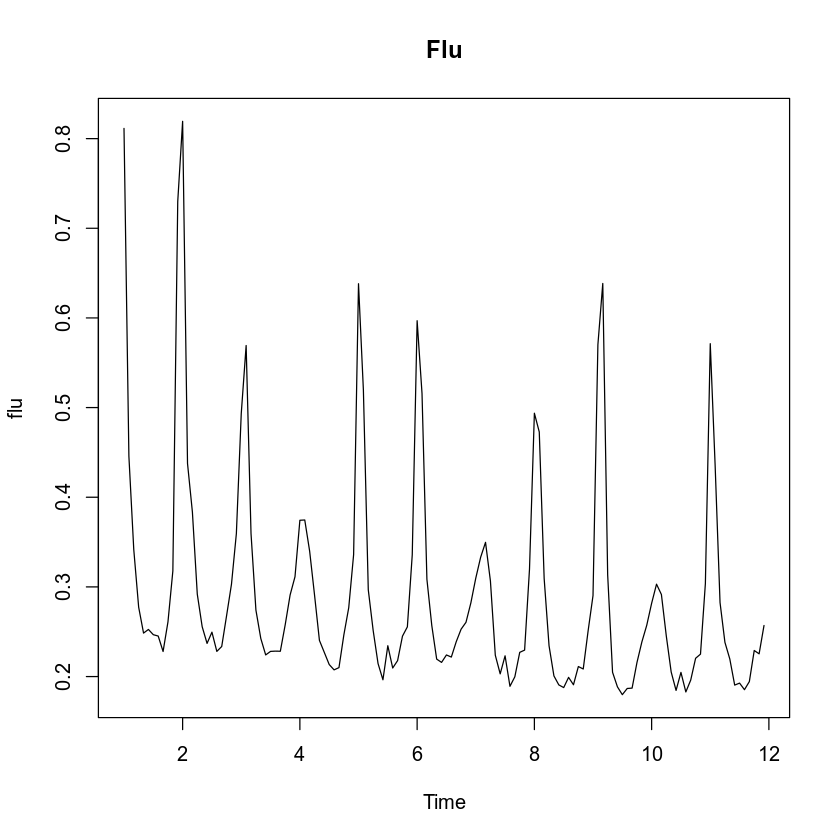

In [2]:
flu <- ts(read.table("https://www.stat.pitt.edu/stoffer/tsa2/data/flu.dat.txt"), frequency=12)
length(flu)
ts.plot(flu, main = 'Flu')

Deseamos estabilizar la varianza, en particular, reducir la dependencia de la variabilidad del tiempo. Para esto, se utilizará la **Media movil**.

In [3]:
rm_flu <- rollmean(flu, 5)
head(rm_flu)

,Mar,Apr,May,Jun,Jul,Aug
1,0.4249440,0.3131781,0.2733503,0.2540707,0.2441794,0.2466861


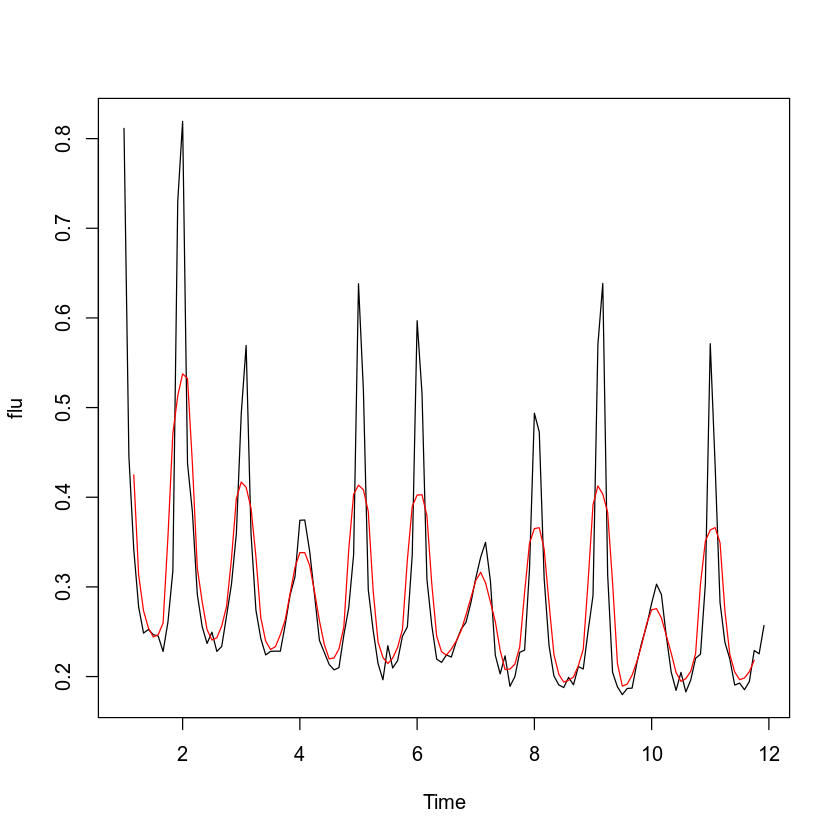

In [4]:
seqplot.ts(flu,rm_flu)

In [5]:
mean(rm_flu)
mean(flu)

[1] 0.2886393

[1] 0.2918623

In [6]:
var(rm_flu)[1,1]
var(flu)[1,1]

[1] 0.006155421

[1] 0.01578173

Podemos ver que se cumple el **Resultado 1.6**, es decir, la media se mantiene relativamente constante y la varianza cambia pues se transforma en $\frac{\sigma^2}{2*q+1}$, donde se usó $q = 5$.

2. Se propone un modelo de la forma
    $$Z_t = \sum_{j=0}^{\infty} \beta_j t^j + \epsilon_t$$
donde $\epsilon_t$ es un ruido blanco con varianza $\sigma^2$.
    1. Proponga un método que permita truncar la serie infinita que define el modelo, de tal modo que el modelo resultante sea de la forma
        $$Z_t = \sum_{j=0}^p b_j t^j + u_t,$$
   donde $p \in \mathbb{N}$. Es decir, proponga un método para estimar p.
    2. Estime $p$ usando los datos de la serie ```flu.dat```.
    3. Estime los parámetros del modelo: $\beta_j$, $j = 0,1,...,\hat p$, donde $\hat p$ es la estimación de $p$ propuesta en B.
**Solución.**

Se propone transformar el modelo de la forma
$$Z_t = \sum_{j=0}^\infty \beta_j t^j + \epsilon_t \quad \Rightarrow \quad Z_t = \sum_{j=0}^p \beta_j t^j + \underbrace{\sum_{j=p+1}^\infty \beta_j t^j + \epsilon_t}_{u_t}$$
donde $u_t \approx N(\sum_{j=p+1}^\infty \beta_j t^j,\sigma^2)$. Para estimar $p$, se propone el siguiente método basado en el filtrado de Diferenciación y la Proposición 1.1.
   
```
FUNCTION obtener_p(datos)
p = 0
while True:
    datos <- diff(datos)
    calcular regresion lineal
    si |pendiente| < tol
        break
    p += 1
return p
```

En particular, utilizando los datos

In [115]:
diff_datos <- rm_flu
p = 0
tol = 10^-5
while(TRUE){
    diff_datos <- diff(diff_datos)
    range <- ts(1:length(diff_datos))
    regression <- lm(diff_datos ~ range)
    slope <- abs(regression$coefficients["range"])
    if(slope < tol){
        break
    }
    p <- p + 1
}
p

[1] 5

De esta forma, se tiene un modelo de regresión lineal, por lo que se calculará utilizando ``lm``.

In [116]:
q <- ts(1:length(flu), frequency=12)
regression <- lm(flu ~ poly(q,p,raw=TRUE))
regression


Call:
lm(formula = flu ~ poly(q, p, raw = TRUE))

Coefficients:
            (Intercept)  poly(q, p, raw = TRUE)1  poly(q, p, raw = TRUE)2  
              4.609e-01               -1.400e-02                4.760e-04  
poly(q, p, raw = TRUE)3  poly(q, p, raw = TRUE)4  poly(q, p, raw = TRUE)5  
             -7.711e-06                5.764e-08               -1.610e-10  


3. Grafique la serie original y la serie ajustada en un mismo gráfico. Hay evidencia para aseverar que el modelo estimado es una buena representación de los patrones de la serie original? Justifique.

In [147]:
intercept = regression$coefficients["(Intercept)"]
range <- 1:length(flu)
regressiondata <- matrix(1, 1, length(flu))*intercept

for(i in 1:p){
    regressiondata <- regressiondata +  1:length(flu)*regression$coefficients[paste("poly(q, p, raw = TRUE)",i, sep = "")]
}

seqplot.ts(flu, regressiondata)

ERROR: Error in seqplot.ts(flu, regressiondata): x or y is not a time series


4. Ajuste un modelo de descomposición a la serie ```flu.dat```.

In [ ]:
flu <- ts(read.table("https://www.stat.pitt.edu/stoffer/tsa2/data/flu.dat.txt"), frequency=12)

```
Se estimará la tendencia a través de un modelo lineal.
```

In [ ]:
ma_flu <- ts(rollmean(flu, 5), frequency=12)
range <- ts(1:length(ma_flu), frequency=12)
regression <- lm(ma_flu ~ range)
regression

In [ ]:
intercept = regression$coefficients["(Intercept)"]
slope = regression$coefficients["range"]
range <- ts(1:length(ma_flu), frequency=12)
trend <- ts(intercept + slope * range, frequency=12)
seqplot.ts(ma_flu, trend, ylab="Flu")

```
Estimamos entonces el modelo estacional
```

In [ ]:
seasonal <- ma_flu - trend

In [ ]:
linearmodel <- ts(trend + seasonal, frequency=12)
seqplot.ts(flu,linearmodel)

5. Ajuste un modelo de Holt-Winters a la serie ```flu.dat```.

In [ ]:
flu <- ts(flu, frequency=12)
hw_flu <- HoltWinters(flu)
plot(hw_flu)
summary(hw_flu)

6. De los modelos propuestos en la parte 2., 4. y 5., ¿cuál es el más apropiado?

El modelo 5. parece ser más apropiado.

---
# Problema 2

En este ejercicio es necesario obtener la serie asociada al calentamiento de la tierra descrito en grados centígrados entre los años 1900-1997. Esta serie es presentada en ```Shumway and Stoffer (2000), página 5```. Para bajar el archivo ```globtemp.dat```, encuentre el sitio web http://www.stat.pitt.edu/stoffer/tsa2/tsa2.html.

1. Grafique la serie ```globtemp.dat``` en el tiempo.

In [ ]:
globtemp <- ts(read.table("https://www.stat.pitt.edu/stoffer/tsa2/data/globtemp.dat.txt"))
head(globtemp)

In [ ]:
ts.plot(globtemp, main='Global Temperature in Time', ylab="Global Temperature")

2. Use un modelo de suavizamiento exponencial simple para predecir la serie hacia el futuro. Considere un valor apropiado para $\alpha$.

```
Debemos recordar que para utilizar un modelo de suavizamiento exponencial simple, se deben quitar las tendencias. Observe que si no:
```

In [ ]:
length(globtemp)

In [ ]:
globtemp.train <- window(globtemp, end = 100)
globtemp.test <- window(globtemp, start = 101)

In [ ]:
ses_globtemp <- ses(globtemp, alpha = .2, h = 100)
autoplot(ses_globtemp)

```
Observamos que no está capturando la tendencia correctamente. Esto es porque el Suavizamiento Exponencial Simple requiere que los datos no tengan tendencia. Para esto, podemos utilizar el comando ```diff```
```

In [ ]:
diff_globtemp <- diff(globtemp)
plot(diff_globtemp)
ses_diff_globtemp <- ses(diff_globtemp, alpha = .2, h = 100)
autoplot(ses_diff_globtemp)

3. Describa las bondades y limitaciones del modelo usado en los puntos anteriores.

```
Entre las bondades que uno puede encontrar, se tiene que le da mayor peso al pasado reciente y menos al pasado remoto, además, al hacer predicciones de un periodo de tiempo adelante, se puede decir que es bastante preciso.

El mayor problema del modelo es que no son precisos al momento de utilizar tendencias, y es por eso que uno debe remover estas para hacer una mejor predicción. Para esto se sugiere que, al graficar y evaluar la forma de la tendencia, utilizar un suavizamiento exponencial de mayor grado.
```

4. A partir de la serie original obtenga una serie sin tendencia.

In [ ]:
diff_globtemp = diff(globtemp)
plot(diff_globtemp)

5. Estime un modelo de regresión de la forma
$$Z_t = \beta_0 + \beta_1 t + \epsilon_t,$$
para la serie ```globtemp.dat```, donde $\epsilon_t$ es una colección de variables aleatorias no correlacionadas en media cero y varianza $\delta^2$. ¿El modelo ajustado luce similar a la serie original?

In [ ]:
range <- ts(1:length(globtemp))
regression <- lm(globtemp ~ range)

intercept = regression$coefficients["(Intercept)"]
slope = regression$coefficients["range"]
trend <- intercept + slope * range

seqplot.ts(globtemp, trend, ylab="Global Temperature")

6. Descomponga la serie ```globtemp.dat``` en tres partes: una tendencia, una parte estacional y una componente residual. Describa que observa.

In [ ]:
dec_globtemp <- ts(globtemp, frequency=12)
dec <- decompose(dec_globtemp)
plot(dec)

```
Podemos observar que los datos poseen una componente estacional notable, asi como la tendencia no se asemeja ni a una forma lineal ni parabólica, por lo que los modelos sugeridos pueden mejorarse.
```

---
# Problema 3


Al analizar cierta serie de tiempo trimestral se usó un método ingenuo obteniéndose:

1. Ecuación de tendencia $T(t) = 84.65 + 4.71t$.
2. Serie de residuos $W(t) = Y(t) - Z(t)$.
| Trimestre | 1997   | 1998   | 1999   | 2000   | 2001 |   |   |   |   |
|:---------:|:------:|:------:|:------:|:------:|:----:|:---:|:---:|:---:|:---:|
| 1         | -      | 20     | 15     | 13.75  | 8.75 |   |   |   |   |
| 2         | -      | -6.25  | -7.50  | -7.50  | 2.50 |   |   |   |   |
| 3         | -11.25 | -11.25 | -21.50 | -13.75 | -    |   |   |   |   |
| 4         | 0.95   | 1.05   | 1.11   | 1.05   | -    |   |   |   |   |

En base a los resultados de 1. y 2., dado que $t = 1$ corresponde al primer trimestre de 1997, prediga los valores de la serie en cada uno de los trimestres de 2002.

**Solución.**

Primero obtendremos los valores de los $e_i$, con $i = 1,...,4$. Note que $e_i$ corresponde al promedio de los $W(t)$ de cada trimestre.
Calculando:

* $e_{1} = (20+15+13.75+8.75)/4 = 14.38$
* $e_2 = (-6.25-7.50-7.50+2.50)/4 = -4.69$
* $e_3 = (-11.25-11.25-21.50-13.75)/4 = -14.44$
* $e_4 = (0.95+1.05+1.11+1.05)/4 = 1.04$

Calculando el promedio de los $e_i$, para $i=1,...,4$

$$\overline{e} = (14.38-4.69-14.44+1.04)/4 = -0.93$$

Por otra parte la estimacion de la componente estacional, está dada por:

* $\hat{E_{1}} = e_1 - \overline{e} = 15.31$
* $\hat{E_{2}} = e_2 - \overline{e} = -3.76$
* $\hat{E_{3}} = e_3 - \overline{e} = -13.51$
* $\hat{E_{4}} = e_4 - \overline{e} = 1.97$

Note que la tendencia viene dada por $T_{t} = 84.65 +4.71*t$, y dado que nos piden predecir los valores de $Z$ para el año 2002, entonces tendremos que calcular los trimestres 21,22,23,24. En efecto:

* $\hat{T_{21}} = 183.56$
* $\hat{T_{22}} = 188.27$
* $\hat{T_{23}} = 192.98$
* $\hat{T_{24}} = 197.69$

Finalmente , calculando lo pedido (los valores de la serie para cada trimestre del año 2002).

* $\hat{Z_{21}} = \hat{T_{21}} + \hat{E_{1}} = 198.87$
* $\hat{Z_{22}} = \hat{T_{22}} + \hat{E_{2}} = 184.51$
* $\hat{Z_{23}} = \hat{T_{23}} + \hat{E_{3}} = 179.47$
* $\hat{Z_{24}} = \hat{T_{24}} + \hat{E_{4}} = 199.66$

---
# Problema 4

Considere una serie de tiempo $\lbrace Z_t : t \in T \rbrace$ descrita por la ecuación:
$$Z_t = \beta_0 + \beta_1 t + \beta_2 t^2 + S_t + \epsilon_t$$
donde $\beta_0$, $\beta_1$ y $\beta_2$ son parámetros desconocidos del modelo, $S_t$ es un efecto estacional conocido y $\epsilon_t$ es un ruido aleatorio con media y varianza constante. Determine las ecuaciones que permiten estimar los parámetros $\beta_0$, $\beta_1$ y $\beta_2$.

Considere el pseudocodigo

```
function [b0,b1,b2] = RegresionPolinomial2(z,t)
    y = transpose(z);
    x = [1 t(1) t(1)^2;1 t(2) t(2)^2;1 t(3) t(3)^2]
    bb = vpa(inv(transpose(x)*x)*transpose(x)*y); %Vector coeficiente de regresion polinomial
    %Este vector se obtiene usando la estimacion de minimos cuadrados
    b0 = bb(1);
    b1 = bb(2);
    b2 = bb(3);
    end
```